In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("D:\data prep\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_bureau_balance.csv")
df.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


# TABLE DESCRIPTION

In [3]:
description = pd.read_csv('D:\data prep\project data\dseb63_columns_description.csv',encoding='latin',index_col=0)
description = description[description['Table'].str.contains('bureau_balance')].drop(columns = 'Table',axis = 0).set_index("Row")
description

,Description,Special
Row,,
SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
STATUS,Status of Credit Bureau loan during the month ...,NaN


# CHECK NULL

In [4]:
number_missing = df.isnull().sum()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'number_missing' : number_missing,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,number_missing,percent_missing
SK_ID_BUREAU,SK_ID_BUREAU,0,0.0
MONTHS_BALANCE,MONTHS_BALANCE,0,0.0
STATUS,STATUS,0,0.0


In [5]:
columns = df.loc[:,(df.isnull().sum(axis = 0) / df.shape[0]) >= 0.9].columns
columns

Index([], dtype='object')

I didn't find any column with >90%null. So removing is not necessary

# CHECK OUTLIERS

<Axes: ylabel='SK_ID_BUREAU'>

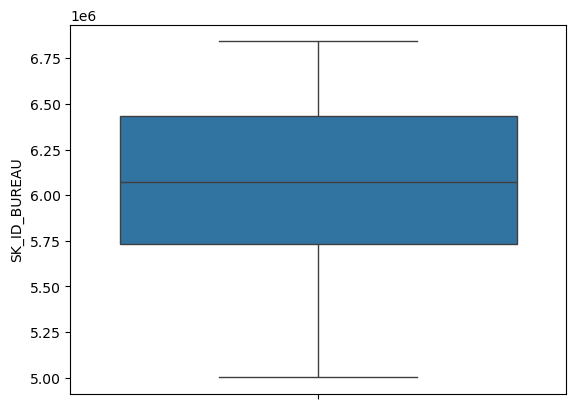

In [6]:
sns.boxplot(df['SK_ID_BUREAU'])

<Axes: ylabel='MONTHS_BALANCE'>

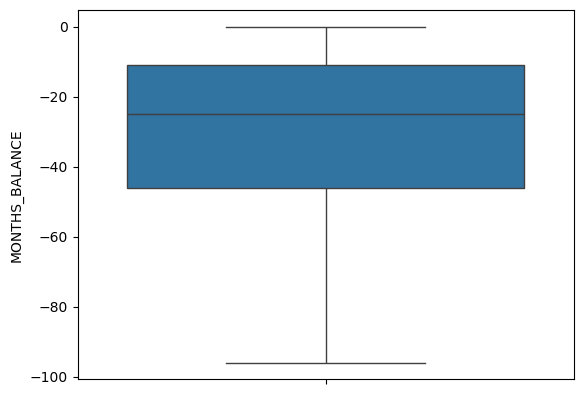

In [7]:
sns.boxplot(df['MONTHS_BALANCE'])

<Axes: ylabel='STATUS'>

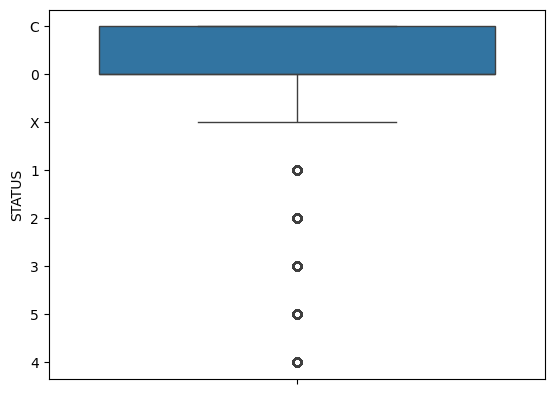

In [8]:
sns.boxplot(df['STATUS'])

# CHECK VALID

In [9]:
numerical_data = df._get_numeric_data()

In [10]:
for column in numerical_data.columns:
    value_counts = numerical_data[column].apply(lambda x: '>0' if x > 0 else ('=0' if x == 0 else '<0')).value_counts()
    
    for cat in ['>0', '=0', '<0']:
        if cat not in value_counts:
            value_counts[cat] = 0
    
    nan_total = numerical_data[column].isnull().sum()
    other_value = numerical_data.shape[0] - value_counts.sum() - nan_total

    print(f'{column} has  >0: {value_counts[">0"]}, =0: {value_counts["=0"]}, <0: {value_counts["<0"]}, nan: {nan_total}, other values: {other_value}')

SK_ID_BUREAU has  >0: 27299925, =0: 0, <0: 0, nan: 0, other values: 0
MONTHS_BALANCE has  >0: 0, =0: 610965, <0: 26688960, nan: 0, other values: 0


In [11]:
categorical_data = df.drop(columns=numerical_data.columns)

In [12]:
for column in categorical_data.columns:
    unique_values = categorical_data[column].unique()
    print(f'col {column} : {list(unique_values)}\n')

col STATUS : ['C', '0', 'X', '1', '2', '3', '5', '4']



# CHECK DISTRIBUTION OF CATEGORICAL

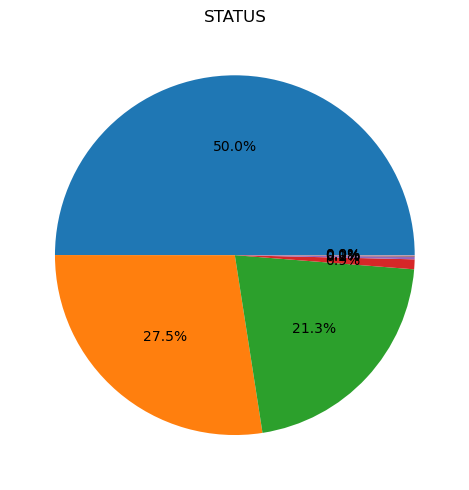

In [13]:
column_name = categorical_data.columns[0]

sizes = categorical_data[column_name].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(5, 5))

ax.pie(sizes, autopct='%1.1f%%')
ax.set_title(column_name, color='black')

plt.tight_layout()
plt.show()

In [20]:
print(f"\nInsights for {column_name}:")
    
for category, percentage in sizes.iteritems():
    print(f"{category}: {percentage * 100:.2f}%")
    
print(f"Total Unique Categories: {len(sizes)}")


Insights for STATUS:
C: 49.99%
0: 27.47%
X: 21.28%
1: 0.89%
5: 0.23%
2: 0.09%
3: 0.03%
4: 0.02%
Total Unique Categories: 8


C:\Users\Admin\AppData\Local\Temp\ipykernel_32\3896291981.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for category, percentage in sizes.iteritems():


# CREATE CORRELATION MATRIX

In [17]:
correlation_matrix = df.corr()
correlation_matrix

C:\Users\Admin\AppData\Local\Temp\ipykernel_32\868109210.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


,SK_ID_BUREAU,MONTHS_BALANCE
SK_ID_BUREAU,1.000000,0.011873
MONTHS_BALANCE,0.011873,1.000000


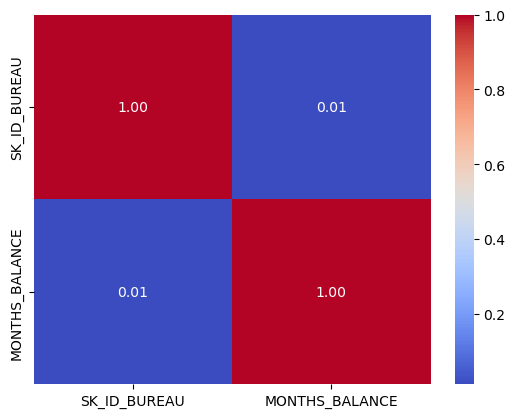

In [21]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [22]:
max_corr = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
min_corr = correlation_matrix.unstack().sort_values().drop_duplicates()
print("Các cặp features có correlation cao nhất:\n", max_corr.head())

Các cặp features có correlation cao nhất:
 SK_ID_BUREAU  SK_ID_BUREAU      1.000000
              MONTHS_BALANCE    0.011873
dtype: float64


# MERGE WITH TARGET TABLE

In [24]:
df2 = pd.read_csv("D:\data prep\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv")
df2 = df2['TARGET']

In [25]:
merge_table = pd.merge(df, df2, left_index=True, right_index=True, how='left')
merge_table.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,TARGET
0,5715448,0,C,0.0
1,5715448,-1,C,0.0
2,5715448,-2,C,0.0
3,5715448,-3,C,0.0
4,5715448,-4,C,0.0


# CHECK DISTRIBUTION OF NUMERICAL

In [27]:
numerical_data.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE'], dtype='object')

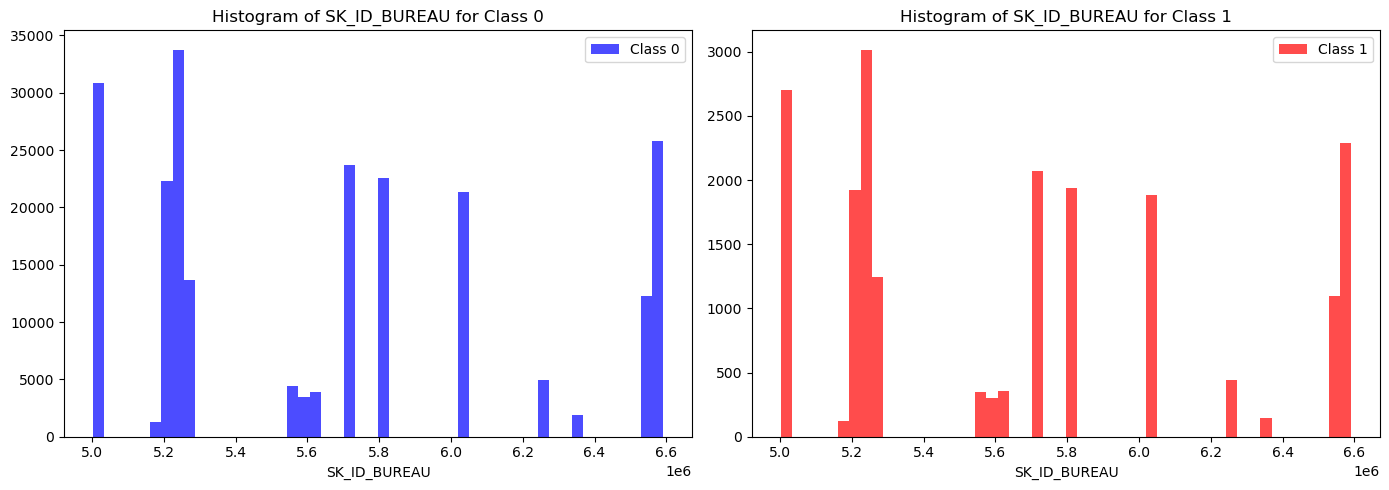

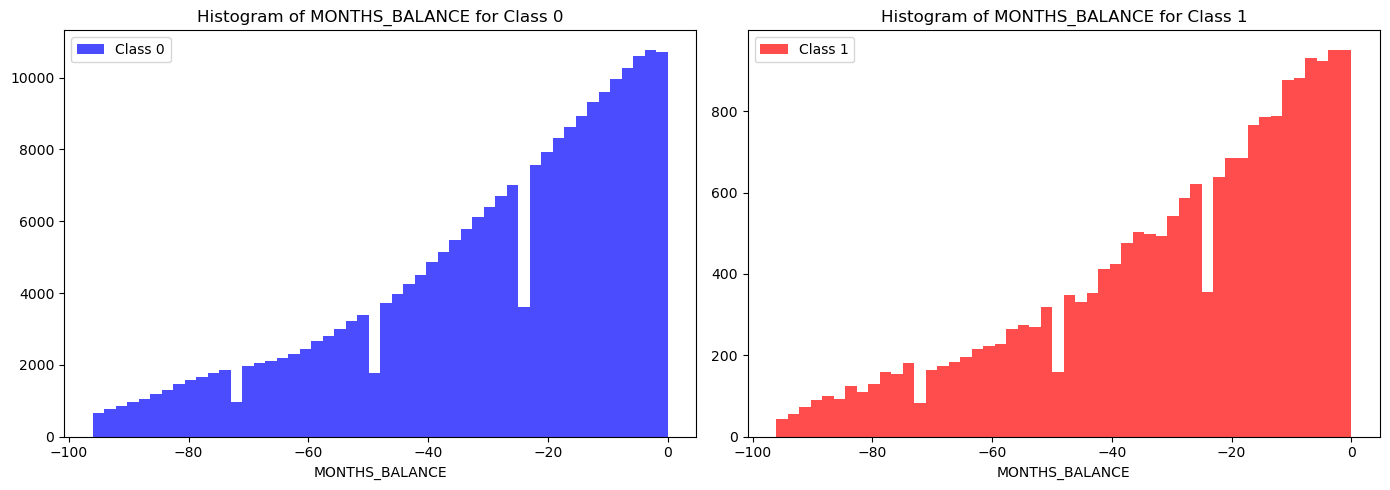

In [28]:
features = ['SK_ID_BUREAU', 'MONTHS_BALANCE']

for feature in features:
    class0 = merge_table[merge_table['TARGET'] == 0][feature]
    class1 = merge_table[merge_table['TARGET'] == 1][feature]

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot histograms
    ax[0].hist(class0, bins=50, alpha=0.7, color='blue', label='Class 0')
    ax[1].hist(class1, bins=50, alpha=0.7, color='red', label='Class 1')
    
    ax[0].set_title(f'Histogram of {feature} for Class 0')
    ax[1].set_title(f'Histogram of {feature} for Class 1')
    
    ax[0].set_xlabel(feature)
    ax[1].set_xlabel(feature)
    
    ax[0].legend()
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

Insight: There is a small difference in the spread of 'MONTHS_BALANCE' between the two classes. 